### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File '03_df_bands_structure_VI_LAI_NDVIc.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

In this file, we will try to use all available predictants for model LAI, we have already generated VIs from a list.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.

- To visualize the results install Jinja2
```bash
conda install jinja2
```



### Running PySR 

Julia and Julia dependencies are installed at first import:

In [7]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [8]:
import warnings
warnings.filterwarnings('ignore')

import sympy
import numpy as np
import pandas as pd
import skill_metrics as sm
import mpl_scatter_density # adds projection='scatter_density'

from pysr import PySRRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Set up PySR run:


using Sergio's data

In [9]:
df = pd.read_csv('03_df_bands_structure_VI_LAI_NDVIc.csv')
# print(df.head())
X = df.iloc[:,1:-3]
y = df.iloc[:,-2]
print(X.head())

        Red     Green      Blue       NIR        FC   c_depth        CH  \
0  0.035958  0.053953  0.005338  0.342562  0.439236  1.429447  1.972603   
1  0.035262  0.053063  0.005320  0.340711  0.383681  1.474576  1.946317   
2  0.038239  0.053274  0.005266  0.329618  0.274306  1.550626  1.988539   
3  0.039237  0.053812  0.005251  0.324419  0.307292  1.559624  2.024439   
4  0.038143  0.049900  0.005562  0.285435  0.130208  1.447568  1.946801   

        AVI        BAI       BCC  ...        SI        SR       SR2      TDVI  \
0  0.466092  11.912866  0.056041  ...  0.968043  9.526727  6.349293  0.568998   
1  0.464776  12.049737  0.056810  ...  0.968585  9.662140  6.420823  0.567705   
2  0.452042  13.070470  0.054412  ...  0.967534  8.619965  6.187242  0.543420   
3  0.446288  13.585168  0.053416  ...  0.967021  8.268284  6.028801  0.532854   
4  0.407953  18.299150  0.059423  ...  0.968618  7.483366  5.720179  0.471239   

        TGI       TVI      TriVI      VARI       VIG   VgNIRBI

key pySR parameters to be changed:

In [10]:
niterations = 100  # for short runs, set this to a 100, for longer runs, set this to 10 million
timeout_in_seconds = 3600*2  # this line will make the code stop after 2 hours, change it as desired.
elementwise_loss = "L2DistLoss()"  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options

binary_operators = ["+", "*","-","/","^"] # these are the default binary operators (use these for basic equations)
# binary_operators = ["+", "*","-","/","^","ND(x,y) = ((x-y)/(x+y))", "SR(x,y)=x/y"]  # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
unary_operators = ["sqrt", "exp", "log", "inv(x)=1/x"]  # other basic operators can be added here
extra_sympy_mappings = {"inv": lambda x: 1 / x,"ND": lambda x, y: ((x- y)/(x+y)),"SR": lambda x, y: x/y}  # here the format of the sought expressions are defined

The default parameters will help speed up code and ensure repeteability of run

In [11]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

In [12]:
# Learn equations
model = PySRRegressor(
    niterations=niterations,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=timeout_in_seconds,  # this line will make the code stop after 2 hours
    binary_operators=binary_operators, # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    unary_operators=unary_operators, # other basic operators can be added here
    extra_sympy_mappings=extra_sympy_mappings, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367379   
	1         0.150384                                          exp(GEMI)   
	2         0.500523                                     3.4357746 / CH   
	3         0.087793                                 exp(2.316047 - CH)   
	4         0.092643                       5.5965652 - (CH * 2.0666535)   
	5         0.396514                         exp((FC + 1.9845617) - CH)   
	6         0.059626                    exp(sqrt(FC) + (1.766392 - CH))   
	7         0.042324           ((sqrt(FC) + 2.5990286) - CH) ^ 1.709856   
	8         0.013454  exp((0.96739984 - CH) + (sqrt(sqrt(FC)) * 1.82...   
	9         0.005456  ((((sqrt(FC) + 1.1915066) * 1.3018438) - CH) +...   
	10  >>>>  0.095240  log(sqrt((DSWI4 + ((2.8810632 - CH) ^ 8.476374...   
	11        0.007660  log(sqrt((((3.1649163 - CH) ^ 9.930234) + 11.6...   
	12        0.005273  log(sqrt(CH + ((11.610489 + ((3.1649163 - CH) ...   
	13        0.001204  log(sqrt(exp(MCARI1) + ((11.610489 + ((3.16491...   
	14        0.007409  log(sqrt(CH + (((MSR / 0.32911038) + ((3.16491...   
	15        0.018330  log(sqrt((((((2.902931 - CH) ^ 9.725767) + 1.6...   
	16        0.001651  log(sqrt((((exp(TDVI) + ((2.902931 - CH) ^ 9.7...   
	17        0.019015  log(((((exp(2.7765129 - CH) ^ 4.409194) * NLI)...   
	18        0.006051  log(((MCARI2 * (((exp(2.739261 - CH) ^ 4.42895...   
	19        0.001843  log((((NLI * (exp(2.739261 - CH) ^ 4.4289527))...   
	20        0.008075  log(((((exp(1.9700654 - CH) ^ 5.025861) / ((0....   
	21        0.000912  (log(((((exp(1.9700654 - CH) ^ 5.025861) / ((0...   
	22        0.014893  log((MCARI2 * (((exp(2.6506524 - CH) ^ 4.95949...   
	23        0.005079  log(((MCARI2 * ((exp(2.6506524 - CH) ^ 4.95949...   
	
	        loss  complexity  
	0   1.291320           1  
	1   1.111022           2  
	2   0.673516           3  
	3   0.616908           4  
	4   0.562323           5  
	5   0.378253           6  
	6   0.356358           7  
	7   0.341590           8  
	8   0.332521          10  
	9   0.328913          12  
	10  0.299033          13  
	11  0.294487          15  
	12  0.291397          17  
	13  0.291047          18  
	14  0.288898          19  
	15  0.283651          20  
	16  0.282716          22  
	17  0.272166          24  
	18  0.262462          30  
	19  0.261496          32  
	20  0.257307          34  
	21  0.256370          38  
	22  0.252580          39  
	23  0.248761          42  
]

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [13]:
best_score=model.get_best().score

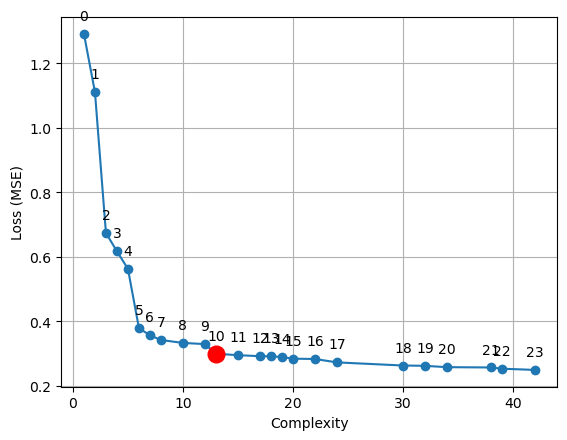

In [14]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [15]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

log(5.30651760012077*sqrt(FC*(DSWI4 + (2.8810632 - CH)**8.476374)))

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [16]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291320,2.367379
1,1.111022,exp(GEMI)
2,0.673516,3.4357746 / CH
3,0.616908,exp(2.316047 - CH)
4,0.562323,5.5965652 - (CH * 2.0666535)
5,0.378253,exp((FC + 1.9845617) - CH)
6,0.356358,exp(sqrt(FC) + (1.766392 - CH))
7,0.341590,((sqrt(FC) + 2.5990286) - CH) ^ 1.709856
8,0.332521,exp((0.96739984 - CH) + (sqrt(sqrt(FC)) * 1.8240374))
9,0.328913,((((sqrt(FC) + 1.1915066) * 1.3018438) - CH) + 0.8758294) ^ 1.6985502


## Output

Plotting the first solutions

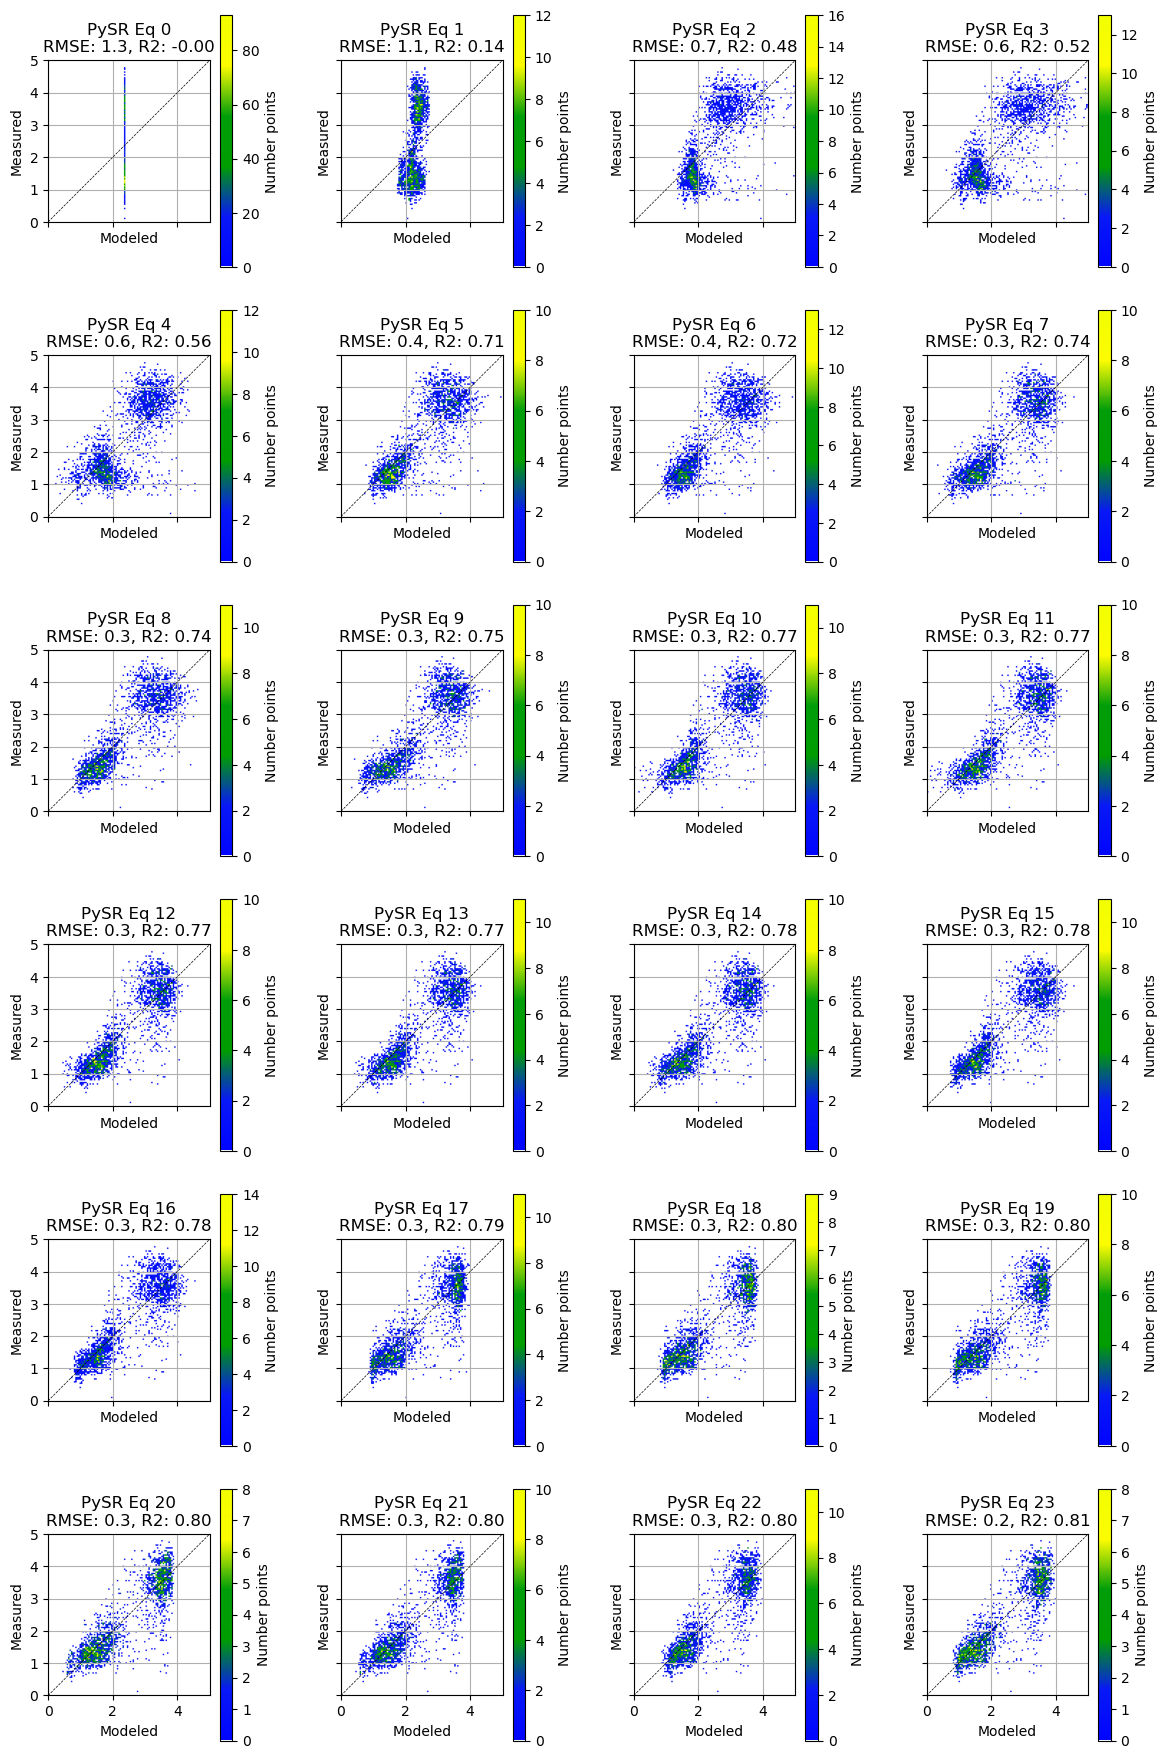

In [ ]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#0004FF"),
    (0.2, "#0818F6"),
    (0.4, "#009d00"),
    (0.6, "#009d0a"),
    (0.8, "#fcfc01"),
    (1, "#f2ff00"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True,subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled")
    ax.set_ylabel("Measured")
    ax.plot( [0,5], [0,5], linestyle='--', color='k', linewidth=0.5 )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

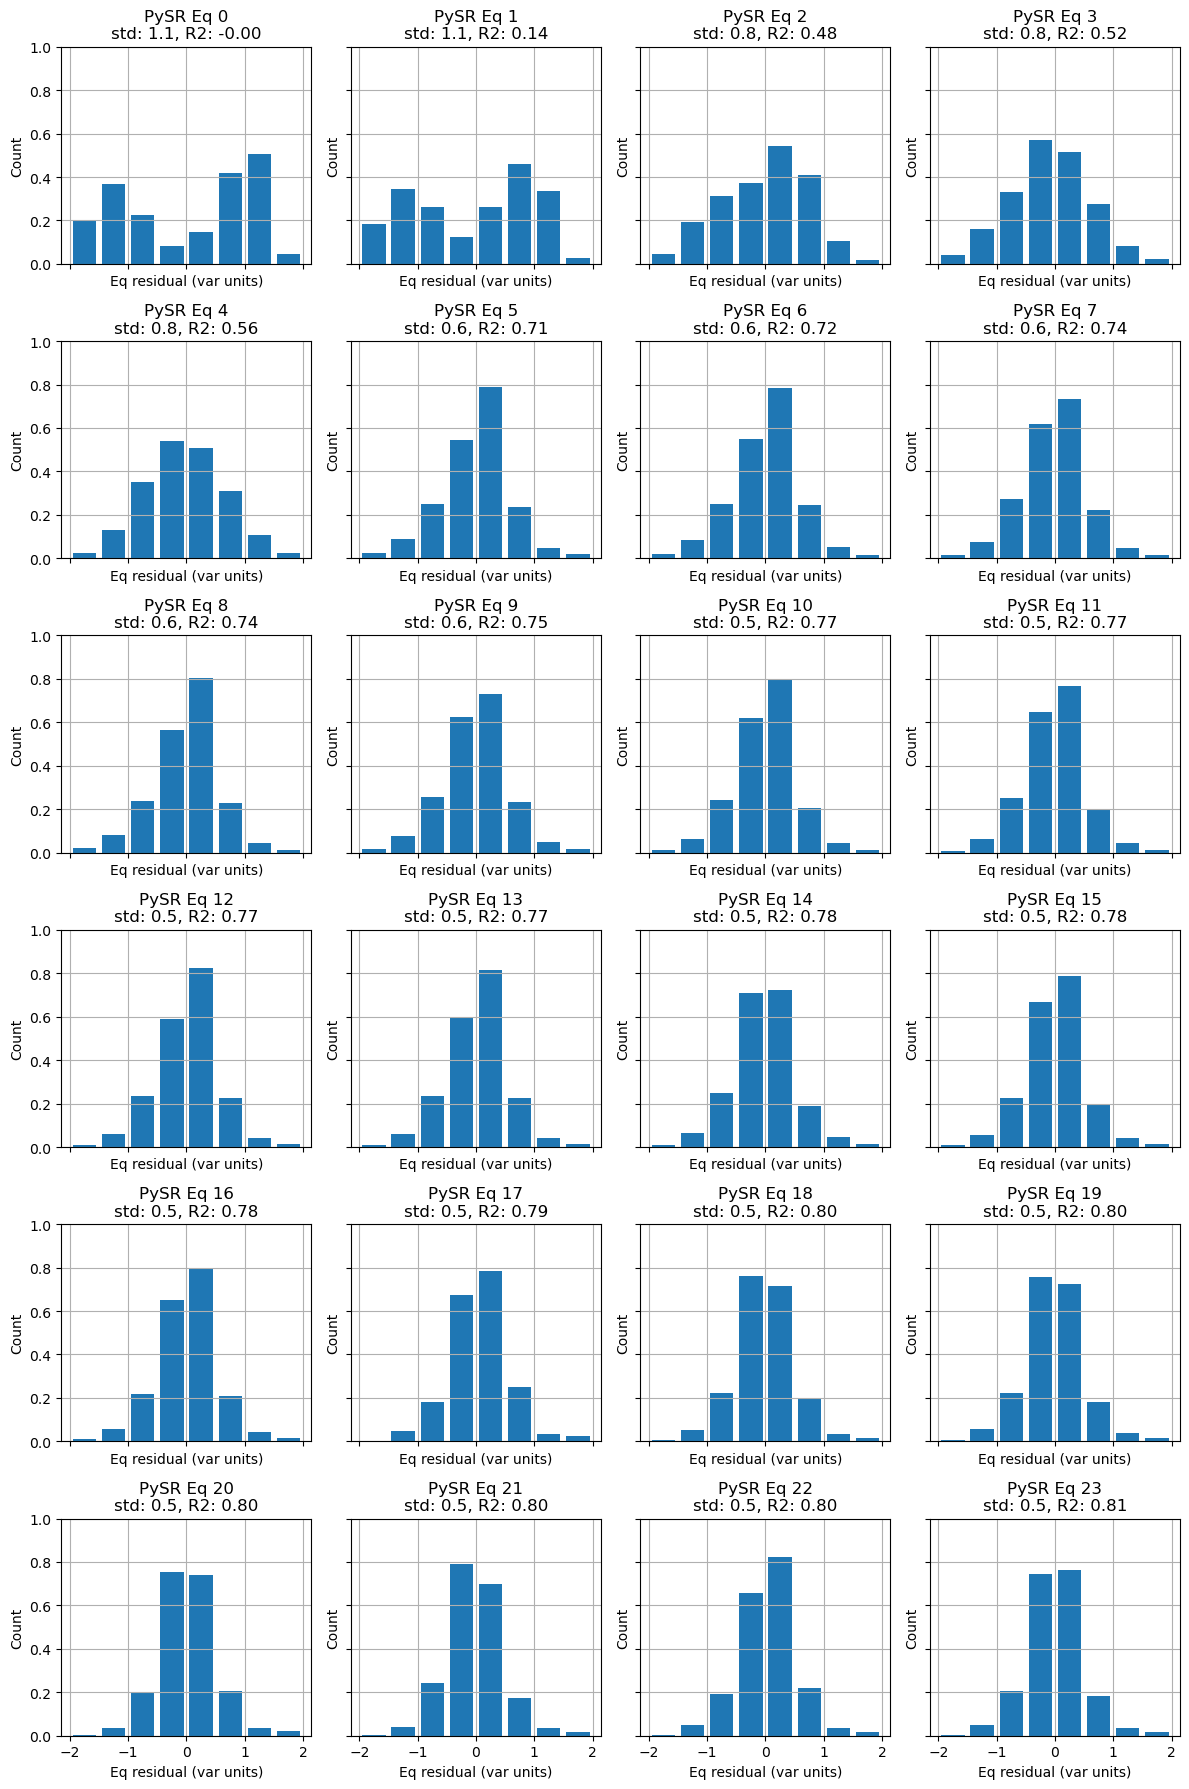

In [18]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Define bin interval and create bin edges
bin_interval = 0.5  # Adjust this value to change bin width
bins = np.arange(-2, 2 + bin_interval, bin_interval)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y, bins=bins, density=True, rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (var units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

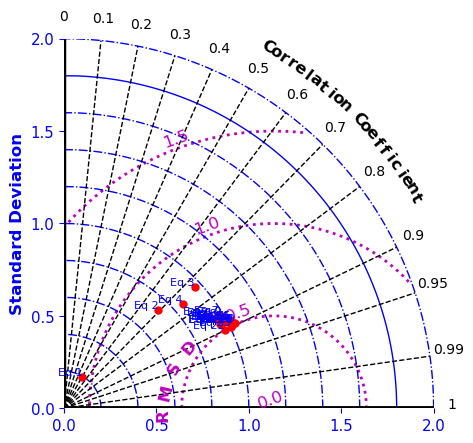

In [19]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api